In [1]:
from __future__ import division

import numpy as np
from numpy import *

import os

import tensorflow as tf

import PIL
from PIL import Image
import matplotlib.pyplot as plt

from skimage import data, io, filters

from matplotlib.path import Path
import matplotlib.patches as patches

import pandas as pd

In [2]:
path_to_strokes =  "tiny/airplane.npy"
X = np.load(path_to_strokes)[()]

In [3]:
print('Example sketch has ', str(shape(X['airplane'][0][0])[0]), ' strokes')
print('Corresponds to photo: ', X['airplane'][1][0])

path_to_source_photos = "../tiny/photo/airplane/"
photo = os.path.join(path_to_source_photos,'n02691156_10151.jpg')

('Example sketch has ', '169', ' strokes')
('Corresponds to photo: ', 'n02691156_10151')


In [4]:
class TinyDataset():
    """tiny airplane dataset of photos and sketches for pix2svg."""

    def __init__(self, npy_file, root_dir, transform=None):
        """
        Args:
            npy_file (string): Path to the numpy file with stroke-5 representation and corresponding photos.
                    # to get stroke-5 representation of svg
                    x['airplane'][0][5]
                    # to get corresponding photos
                    x['airplane'][1][5]
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.stroke_dir = npy_file
        self.photo_dir = os.path.join(root_dir,'photo')
        self.strokes = np.load(npy_file)[()]
        self.transform = transform
    
    def __len__(self):
        return len(self.strokes['airplane'][0])

    def __getitem__(self, idx):
        img_name = os.path.join(self.photo_dir,'airplane',X['airplane'][1][idx]+ '.jpg')
        photo = io.imread(img_name)
        photo = photo.astype(float)
        strokes = self.strokes['airplane'][0][idx]
        sample = {'photo': photo, 'strokes': strokes,'name': X['airplane'][1][idx]+ '.jpg'}
        
        if self.transform:
            sample = self.transform(sample)

        return sample    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, strokes, name = sample['photo'], sample['strokes'], sample['name']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))        
        return {'tensor': tf.divide(tf.stack(sample['photo']),255),
                'strokes': strokes,
                'name': name,
                'photo': image}    

def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result    
    
def strokes_to_lines(strokes):
    """
    Convert stroke-3 format to polyline format.
    List contains sublist of continuous line segments (strokes).    
    """
    x = 0
    y = 0
    lines = []
    line = []
    for i in range(len(strokes)):
        if strokes[i, 2] == 1:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
            lines.append(line)
            line = []
        else:
            x += float(strokes[i, 0])
            y += float(strokes[i, 1])
            line.append([x, y])
    return lines

def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y)            
    return verts, codes

def path_renderer(verts, codes):
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2)
    ax.add_patch(patch)
    ax.set_xlim(0,max(max(verts)))
    ax.set_ylim(0,max(max(verts)))
    ax.axis('off')
    plt.gca().invert_yaxis() # y values increase as you go down in image
    plt.show()

In [5]:
%ls

batch_render_tiny_intermediates.ipynb  MNIST_data/  tf_sketchy.ipynb
checkpoints/                           pix2svg/     tiny/
helpers.py                             README.md    ___tiny_intermediates/
helpers.pyc                            sketchy/     tiny_intermediates/
LICENSE                                test.png     tiny_intermediates_resized/


In [6]:
## load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',root_dir='/home/jefan/ptsketchy/tiny',transform=None)

(100, (256, 256, 3), (99, 5))


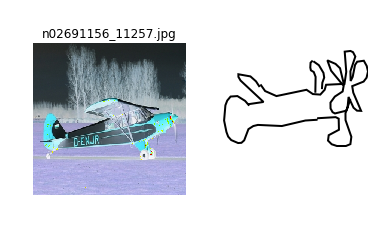

In [7]:
## display given photo and corresponding sketch from stroke-5 representation
i = 100
sample = airplanes[i]
print(i, sample['photo'].shape, sample['strokes'].shape)

plt.figure()
ax = plt.subplot(121)
ax.set_title(sample['name'])
ax.axis('off')
img = np.reshape(sample['photo'],(256,256,3))
plt.imshow(img,interpolation='nearest')

ax = plt.subplot(122)
lines = strokes_to_lines(to_normal_strokes(sample['strokes']))
verts,codes = polyline_pathmaker(lines)
path_renderer(verts,codes)

plt.show()

In [8]:
# load in airplanes dataset
airplanes = TinyDataset(npy_file='/home/jefan/ptsketchy/tiny/airplane.npy',
                        root_dir='/home/jefan/ptsketchy/tiny',
                        transform=ToTensor())

In [9]:
# load in features for photos
path_to_features = 'sketchy/triplet_features'
photo_features = np.load(os.path.join(path_to_features,'photo_features.npy'))
F = photo_features

In [10]:
# read in filenames and generate pandas dataframe with object labels
_filenames = pd.read_csv(os.path.join(path_to_features,'photo_filenames.txt'),header=None,names=['filename'])

filenames = []
for i in range(len(_filenames)):
    filenames.append(_filenames[_filenames.index==i].values[0][0])
filenames = ['sketchy' + f[1:] for f in filenames]
path = filenames
obj = [f.split('/')[3] for f in filenames]
img = [f.split('/')[4] for f in filenames]

data = {'path': path,
         'object': obj,
         'filename': img}
X = pd.DataFrame.from_dict(data)

In [11]:
# subset airplane features only
matches = X['object']=='airplane'
inds = np.where(matches==True)
X0 = X[matches]
F0 = F[inds]

In [12]:
# construct (11094,1024) version of photo feature matrix, called PF, that matches indexing of the sketch feature matrix
sketch_features = np.load('sketchy/airplane_features/airplane_sketch_features.npy')
_sketch_filenames = pd.read_csv('sketchy/airplane_features/airplane_sketch_filenames.txt',header=None,names=['filename'])
sketch_filenames = []
for i in range(len(_sketch_filenames)):
    sketch_filenames.append(_sketch_filenames[_sketch_filenames.index==i].values[0][0])
PF = []
inds = [] 
for sf in sketch_filenames:
    q = sf.split('/')[2]+'.jpg'
    PF.append(F0[X0['filename']==q])
    inds.append(np.where(X0['filename']==q)[0][0])
PF = np.squeeze(np.array(PF))
SF = sketch_features
inds = np.array(inds)

## zip together/concatenate the photo and sketch features
_F = np.hstack((PF,SF))

In [13]:
### now get a (11094,5) representation of the 'next stroke'
### no wait, instead, just bump up the dimensionality of these feature matrices to fit that of 
### the (delta_x,delta_y) stroke representation
### Strokes dataframe ("S") is of dimensionality (55855,5).
### So, resize and re-index the feature matrix to match S. 

S = pd.read_csv('tiny/stroke_dataframe.csv')
S1 = S
photo_dir = np.array([sf.split('/')[2] for sf in sketch_filenames]) # photo dir
sketch_dir = np.array(map(int,[sf.split('/')[3] for sf in sketch_filenames])) # sketch dir
stroke_png = np.array(map(int,[sf.split('/')[4].split('.')[0] for sf in sketch_filenames])) # stroke png

F = []
for index, row in S.iterrows():
    # get ind of the original small (11094,5) matrix that corresponds to this row of S (55855,5)
    ind = np.intersect1d(np.intersect1d(np.where(photo_dir==row['photoID']),
              np.where(sketch_dir==row['sketchID'])),
              np.where(stroke_png==row['strokeID']))[0]
    F.append(_F[ind])
    
F = np.array(F)
F1 = F # protected F1 matrix

### convert strokes matrix from absolute to relative coordinates 

In [23]:
from copy import deepcopy
unique_photos = np.unique(S1.photoID)
r = pd.DataFrame(columns=list(S1.keys()))

run_this = False
if run_this:
    for i, p in enumerate(unique_photos):
        print 'Processing ' + p + ': ' + str(i+1) + ' of ' + str(len(unique_photos)) + ' photos.'
        s1 = S1[S1.photoID==p]
        unique_sketches_of_photo = np.unique(s1.sketchID)
        for sketch in unique_sketches_of_photo:
            this_sketch = s1[s1.sketchID==sketch]
            for index, row in this_sketch.iterrows():
                _row = deepcopy(row)
                if index==min(this_sketch.index): # first stroke
                    r = r.append(row)
                    this_x = row.x
                    this_y = row.y
                else:
                    x_offset = _row.x-this_x
                    y_offset = _row.y-this_y
                    row.x = x_offset
                    row.y = y_offset
                    r = r.append(row)
                this_x = _row.x # hold onto current row so you can compute difference with next one
                this_y = _row.y
    # save out relative strokes matrix as S2
    S2 = r   
    print 'Saving out stroke_dataframe_relative.csv'
    S2.to_csv('tiny/stroke_dataframe_relative.csv')

In [27]:
# check if S2 exists, if not, load it in
try:
    S2
except:
    S2 = pd.read_csv('tiny/stroke_dataframe_relative.csv')
    
# define S to either be ABSOLUTE strokes matrix (S1) or RELATIVE strokes matrix (S2)
S = S2

# generate 55855-long vector of photo indices
print 'generating list of photo indices based on X0'
inds = [] 
for index, row in S.iterrows():
    q = row['photoID']+'.jpg'
    inds.append(np.where(X0['filename']==q)[0][0])
inds = np.array(inds)

# generate random index to do train/val/test split
print 'generating random index to do train/val/test split'
_idx = np.arange(len(X0))
np.random.seed(seed=0)
np.random.shuffle(_idx)
train_len = int(len(_idx)*0.85)
val_len = int(len(_idx)*0.05)
test_len = int(len(_idx*0.10))

# indices of 100 photos that will go into train/val/test split
train_inds = _idx[:train_len] 
val_inds = _idx[train_len:train_len+val_len]
test_inds = _idx[train_len+val_len:len(_idx)]

print 'constructing 55855 vectors that correspond to membership in train/val/test splits'
# construct 55855 vectors that correspond to membership in train/val/test splits
train_vec = np.zeros(len(F)).astype(bool)
val_vec = np.zeros(len(F)).astype(bool)
test_vec = np.zeros(len(F)).astype(bool)

for i in train_inds:
    train_vec[inds==i] = True
for i in val_inds:
    val_vec[inds==i] = True    
for i in test_inds:
    test_vec[inds==i] = True 
    
assert sum(train_vec)+ sum(val_vec) + sum(test_vec) == len(train_vec)    
print ' '
print str(sum(train_vec)/len(train_vec) * len(F)) + ' sketch intermediates to train on.'
print str(sum(val_vec)/len(val_vec) * len(F)) + ' sketch intermediates to validate on.'
print str(sum(test_vec)/len(test_vec) * len(F)) + ' sketch intermediates to test on.'    
print ' '
print 'Now actually splitting data.'
# now actually split data
F_train = F[train_vec]
F_val = F[val_vec]
F_test = F[test_vec]

S_train = S[train_vec]
S_val = S[val_vec]
S_test = S[test_vec]

S_train = S_train[['x', 'y', 'pen']].copy()
S_val = S_val[['x', 'y', 'pen']].copy()
S_test = S_test[['x', 'y', 'pen']].copy()

generating list of photo indices based on X0
generating random index to do train/val/test split
constructing 55855 vectors that correspond to membership in train/val/test splits
 
45041.0 sketch intermediates to train on.
4185.0 sketch intermediates to validate on.
6629.0 sketch intermediates to test on.
 
Now actually splitting data.


In [28]:
## training helpers
def minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx] 

def minibatches(data, batch_size, shuffle=True):
    batches = [np.array(col) for col in zip(*data)]
    return get_minibatches(batches, batch_size, shuffle)

def get_minibatches(data, minibatch_size, shuffle=True):
    """
    Iterates through the provided data one minibatch at at time. You can use this function to
    iterate through data in minibatches as follows:
        for inputs_minibatch in get_minibatches(inputs, minibatch_size):
            ...
    Or with multiple data sources:
        for inputs_minibatch, labels_minibatch in get_minibatches([inputs, labels], minibatch_size):
            ...
    Args:
        data: there are two possible values:
            - a list or numpy array
            - a list where each element is either a list or numpy array
        minibatch_size: the maximum number of items in a minibatch
        shuffle: whether to randomize the order of returned data
    Returns:
        minibatches: the return value depends on data:
            - If data is a list/array it yields the next minibatch of data.
            - If data a list of lists/arrays it returns the next minibatch of each element in the
              list. This can be used to iterate through multiple data sources
              (e.g., features and labels) at the same time.
    """
    list_data = type(data) is list and (type(data[0]) is list or type(data[0]) is np.ndarray)
    data_size = len(data[0]) if list_data else len(data)
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [minibatch(d, minibatch_indices) for d in data] if list_data \
            else minibatch(data, minibatch_indices), minibatch_indices

# usage notes:
# for m in get_minibatches([F_train,S_train.as_matrix()],batch_size,shuffle=True):
#     print len(m),m[0].shape,m[1].shape

### quality assurance make sure that image classification is working as advertised based on triplet features

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm

# reminders:
# S1 is stroke matrix
# F1 is feature matrix
# PF is photo-feature matrix
# SF is sketch-feature matrix

# get np.array of source photo labels
photos = np.array([sf.split('/')[2] for sf in sketch_filenames])

In [30]:
# split sketch feature data for linear classification
X_train, X_test, y_train, y_test = train_test_split(
    SF, photos, test_size=0.2, random_state=0)

# check dimensionality of split data
print 'dimensionality of train/test split'
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape
print ' '
run_this = 0
cval = True
if run_this:
    if cval==False:
        # compute linear classification accuracy (takes a minute or so to run)
        clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
        clf.score(X_test, y_test)   
    else:
        # compute linear classification accuracy (takes several minutes to run)       
        clf = svm.SVC(kernel='linear', C=1)
        scores = cross_val_score(clf, SF, photos, cv=5)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        ## Accuracy: 0.41 (+/- 0.08) achieved on 6/26/17

dimensionality of train/test split
(8875, 1024) (8875,)
(2219, 1024) (2219,)
 


### draft of model for single minibatch

In [31]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

# reset entire graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# weight on offset loss
offset_weight = 100.

# learning rate
learning_rate = 0.01

# get minibatch
batch_size = 10
F_batch = F_train[:batch_size,:]
S_batch = S_train.head(n=batch_size)

# reserve numpy version 
F_batch_array = F_batch
S_batch_array = S_batch.as_matrix().astype('float32')

# convert to tensorflow tensor
F_batch = tf.cast(tf.stack(F_batch,name='F_batch'),tf.float32)
S_batch = tf.cast(tf.stack(S_batch.as_matrix().astype('float32'),name='S_batch'),tf.float32)

# Layer's sizes
x_size = F_batch.shape[1]   # Number of input nodes: 2048 features and 1 bias
h_size = 256                # Number of hidden nodes
y_size = S_batch.shape[1]   # Number of outcomes (x,y,pen)

# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])
output = tf.placeholder("float", shape=[None,y_size])

# Weight initializations
W1 = tf.get_variable('W1', [x_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b1 = tf.get_variable('b1', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

W2 = tf.get_variable('W2', [h_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b2 = tf.get_variable('b2', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

W3 = tf.get_variable('W3', [h_size, y_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b3 = tf.get_variable('b3', [y_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

# forward propagation
fc1 = tf.nn.relu(tf.nn.xw_plus_b(F_batch, W1, b1,name='fc1'))
fc2 = tf.nn.relu(tf.nn.xw_plus_b(fc1, W2, b2,name='fc2'))
output = tf.nn.xw_plus_b(fc1, W3, b3,name='output')

actual_offset = tf.slice(S_batch,[0,0],[batch_size,2])
actual_pen = tf.slice(S_batch,[0,2],[batch_size,-1]) 
pred_offset = tf.multiply(tf.slice(output,[0,0],[batch_size,2]),offset_weight)
pred_pen = tf.nn.softmax(tf.slice(output,[0,2],[batch_size,-1]))
# currently doesn't properly handle the pen state loss
offset_loss = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(pred_offset,actual_offset)),axis=1)))
pen_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels = actual_pen,
            logits = pred_pen))

loss = tf.add(offset_loss,pen_loss)

# run backprop
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# # get predicted stroke vector
strokes = tf.concat([pred_offset, pred_pen],axis=1)

tf.global_variables_initializer().run()


# sess.close()

In [32]:
updates = sess.run([fc1,output,pred_offset,
                    pred_pen,actual_offset, actual_pen,
                    offset_loss,pen_loss,loss,
                    train_op,strokes], feed_dict={X:F_batch_array,y:S_batch_array})

In [140]:
fc1 = updates[0]
output = updates[1]
pred_offset = updates[2]
pred_pen = updates[3]
actual_offset = updates[4]
actual_pen = updates[5]
offset_loss = updates[6]
pen_loss = updates[7]
loss = updates[8]
train_op = updates[9]
strokes = updates[10]



TensorShape([Dimension(None), Dimension(2048)])

###  run multiple batches of MLP version

In [174]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

# reset entire graph
tf.reset_default_graph()

# weight on offset loss
offset_weight = 0.1

# amount to multiply predicted offset values by
offset_multiplier = 100.

# learning rate
learning_rate = 0.001

# set batch size
batch_size = 10

# epoch counter
epoch_num = 0

# feed in only current features, or also features on the next time step as well?
now_plus_next = True

# initialize variables
if now_plus_next:
    F = tf.placeholder("float", shape=[None, 4096])  # features (input)
else:
    F = tf.placeholder("float", shape=[None, 2048])  # features (input)
S = tf.placeholder("float", shape=[None, 3]) # strokes (output)

# Layer's sizes
x_size = F.shape[1]   # Number of input nodes: 2048 features and 1 bias
h_size = 256        # Number of hidden nodes
y_size = S.shape[1]   # Number of outcomes (x,y,pen)

output = tf.placeholder("float", shape=[None,y_size])

# convert to tensorflow tensor
F = tf.cast(tf.stack(F,name='F'),tf.float32)
S = tf.cast(tf.stack(S,name='S'),tf.float32)

# Weight initializations
W1 = tf.get_variable('W1', [x_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b1 = tf.get_variable('b1', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

W2 = tf.get_variable('W2', [h_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b2 = tf.get_variable('b2', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

W3 = tf.get_variable('W3', [h_size, y_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b3 = tf.get_variable('b3', [y_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

# forward propagation
fc1 = tf.nn.relu(tf.nn.xw_plus_b(F, W1, b1,name='fc1'))
fc2 = tf.nn.relu(tf.nn.xw_plus_b(fc1, W2, b2,name='fc2'))
output = tf.nn.xw_plus_b(fc1, W3, b3,name='output')

actual_offset = tf.slice(So,[0,0],[batch_size,2])
actual_pen = tf.squeeze(tf.slice(So,[0,2],[batch_size,-1]))
pred_offset = tf.multiply(tf.slice(output,[0,0],[batch_size,2]),offset_multiplier)
pred_pen = tf.squeeze(tf.slice(output,[0,2],[batch_size,-1]))

offset_loss = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(pred_offset,actual_offset)),axis=1)))
pen_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels = actual_pen,
            logits = pred_pen))

loss = tf.add(tf.multiply(offset_weight,offset_loss),pen_loss)

# run backprop
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# saver
save = False
saver = tf.train.Saver()

# get predicted stroke vector
strokes = tf.concat([pred_offset, tf.expand_dims(pred_pen,1)],axis=1)

# run batches
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for m,idx in get_minibatches([F_train,S_train.as_matrix().astype('float32')],batch_size,shuffle=True):        
        
        if m[0].shape[0]==batch_size:
            F_batch = m[0]
            S_batch = m[1] 
            
            # use idx to retrieve the features of the subsequent row in the feature matrix, so you
            # effectively feed in sketch_so_far and sketch_so_far_plus_next_xy, as well as pen (absolute?) location and state
            if (max(idx)<45040):
                F_batch_next = F_train[idx+1].shape 
                F_now_plus_next = np.hstack((F_train[idx],F_train[idx+1]))
            
            if (now_plus_next) & (max(idx)<45040):
                updates = sess.run([offset_loss, pen_loss, loss, pred_offset], feed_dict={F:F_now_plus_next,S:S_batch})
            else:
                try:
                    updates = sess.run([offset_loss, pen_loss, loss, pred_offset], feed_dict={F:F_batch,S:S_batch}) 
                except:
                    pass

            offset_loss_ = updates[0]
            pen_loss_ = updates[1]
            loss_ = updates[2]
            pred_offset_ = updates[3]

            if epoch_num%200==0:
                print "Epoch: " + str(epoch_num) + " | Loss: " + str(loss_) + \
                " | Offset loss: " + str(offset_loss_) + " | Pen loss: " + str(pen_loss_)

            # save
            if save:
                saver.save(sess, 'checkpoints/pix2svg_train_0')
                
            # increment epoch number
            epoch_num += 1


Epoch: 0 | Loss: 84.0293 | Offset loss: 840.293 | Pen loss: 0.0
Epoch: 200 | Loss: 75.3537 | Offset loss: 753.537 | Pen loss: 0.0
Epoch: 400 | Loss: 62.7308 | Offset loss: 627.308 | Pen loss: 0.0
Epoch: 600 | Loss: 91.7668 | Offset loss: 917.668 | Pen loss: 0.0
Epoch: 800 | Loss: 75.3772 | Offset loss: 753.772 | Pen loss: 0.0
Epoch: 1000 | Loss: 93.3541 | Offset loss: 933.542 | Pen loss: 0.0
Epoch: 1200 | Loss: 109.171 | Offset loss: 1091.71 | Pen loss: 0.0
Epoch: 1400 | Loss: 80.5503 | Offset loss: 805.503 | Pen loss: 0.0
Epoch: 1600 | Loss: 75.5271 | Offset loss: 755.271 | Pen loss: 0.0
Epoch: 1800 | Loss: 95.5452 | Offset loss: 955.452 | Pen loss: 0.0
Epoch: 2000 | Loss: 65.8117 | Offset loss: 658.117 | Pen loss: 0.0
Epoch: 2200 | Loss: 67.3274 | Offset loss: 673.274 | Pen loss: 0.0
Epoch: 2400 | Loss: 68.7728 | Offset loss: 687.728 | Pen loss: 0.0
Epoch: 2600 | Loss: 69.6411 | Offset loss: 696.411 | Pen loss: 0.0
Epoch: 2800 | Loss: 62.5381 | Offset loss: 625.381 | Pen loss: 0.0
Ep

In [ ]:
## meeting notes
# june 26: validate triplet network to make sure it does the task -- QA
# does it take in pen location? put in pen location, pen state 
# put in sketch so far + (sketch so far +1)
# delta x, delta y -- make sure the thing it spits out, after getting squashed by tanh, or whatever, is well centered


### simpler version that goes from last k pen offsets to next pen offset

In [57]:
## now try simpler version that just tries to predict the next offset based on previous offset 

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

# reset entire graph
tf.reset_default_graph()

# weight on offset loss
offset_weight = 0.8

# amount to multiply predicted offset values by
offset_multiplier = 100.

# learning rate
learning_rate = 0.001

# set batch size
batch_size = 10

# epoch counter
epoch_num = 0

# initialize variables
Si = tf.placeholder("float", shape=[None, 3]) # strokes (input)
So = tf.placeholder("float", shape=[None, 3]) # strokes (output)

# Layer's sizes
x_size = Si.shape[1]   # Number of input nodes: x, y, state
h_size = 256        # Number of hidden nodes
y_size = So.shape[1]   # Number of outcomes (x,y,pen)

output = tf.placeholder("float", shape=[None,y_size])

# convert to tensorflow tensor
Si = tf.cast(tf.stack(Si,name='Si'),tf.float32)
So = tf.cast(tf.stack(So,name='So'),tf.float32)

# Weight initializations
W1 = tf.get_variable('W1', [x_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b1 = tf.get_variable('b1', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

W2 = tf.get_variable('W2', [h_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b2 = tf.get_variable('b2', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

W3 = tf.get_variable('W3', [h_size, y_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
b3 = tf.get_variable('b3', [y_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

# forward propagation
fc1 = tf.nn.relu(tf.nn.xw_plus_b(Si, W1, b1,name='fc1'))
fc2 = tf.nn.relu(tf.nn.xw_plus_b(fc1, W2, b2,name='fc2'))
output = tf.nn.xw_plus_b(fc1, W3, b3,name='output')

actual_offset = tf.slice(So,[0,0],[batch_size,2])
actual_pen = tf.squeeze(tf.slice(So,[0,2],[batch_size,-1]))
pred_offset = tf.multiply(tf.slice(output,[0,0],[batch_size,2]),offset_multiplier)
pred_pen = tf.squeeze(tf.slice(output,[0,2],[batch_size,-1]))

offset_loss = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(pred_offset,actual_offset)),axis=1)))
pen_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels = actual_pen,
            logits = pred_pen))

loss = tf.add(tf.multiply(offset_weight,offset_loss),tf.multiply(1-offset_weight,pen_loss))

# run backprop
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# saver
save = False
saver = tf.train.Saver()

# get predicted stroke vector
strokes = tf.concat([pred_offset, tf.expand_dims(tf.round(tf.sigmoid(pred_pen_)+1),1)],axis=1)
Strokes = []

# run batches
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for m,idx in get_minibatches(S_train.as_matrix().astype('float32')[:len(S_train)-1],batch_size,shuffle=True):        

            Si_batch = m # batch of current strokes 
            
            if (max(idx)<45040):
                So_batch = S_train.iloc[idx+1].as_matrix().astype('float32')
                
            updates = sess.run([offset_loss, pen_loss, loss, pred_offset, actual_pen, pred_pen, strokes], feed_dict={Si:Si_batch,So:So_batch}) 

            offset_loss_ = updates[0]
            pen_loss_ = updates[1]
            loss_ = updates[2]
            pred_offset_ = updates[3]
            actual_pen_ = updates[4]
            pred_pen_ = updates[5]
            strokes_ = updates[6]
            
            if epoch_num%200==0:
                print "Epoch: " + str(epoch_num) + " | Loss: " + str(loss_) + \
                " | Offset loss: " + str(offset_loss_) + " | Pen loss: " + str(pen_loss_) 

            # save
            if save:
                saver.save(sess, 'checkpoints/pix2svg_train_svg2svg_0')
                
            # increment epoch number
            epoch_num += 1


Epoch: 0 | Loss: 6238.2 | Offset loss: 7770.56 | Pen loss: 108.733
Epoch: 200 | Loss: 8921.65 | Offset loss: 11040.7 | Pen loss: 445.543
Epoch: 400 | Loss: 2699.67 | Offset loss: 3358.18 | Pen loss: 65.6375
Epoch: 600 | Loss: 6129.35 | Offset loss: 7643.63 | Pen loss: 72.2346
Epoch: 800 | Loss: 5928.16 | Offset loss: 7343.61 | Pen loss: 266.337
Epoch: 1000 | Loss: 6347.5 | Offset loss: 7908.23 | Pen loss: 104.589
Epoch: 1200 | Loss: 6058.09 | Offset loss: 7526.02 | Pen loss: 186.368
Epoch: 1400 | Loss: 5450.67 | Offset loss: 6770.99 | Pen loss: 169.398
Epoch: 1600 | Loss: 4153.09 | Offset loss: 5176.47 | Pen loss: 59.5743
Epoch: 1800 | Loss: 10969.2 | Offset loss: 13681.1 | Pen loss: 121.768
Epoch: 2000 | Loss: 6845.51 | Offset loss: 8525.36 | Pen loss: 126.124
Epoch: 2200 | Loss: 9779.76 | Offset loss: 12198.1 | Pen loss: 106.439
Epoch: 2400 | Loss: 10367.2 | Offset loss: 12898.4 | Pen loss: 242.525
Epoch: 2600 | Loss: 3580.57 | Offset loss: 4412.76 | Pen loss: 251.821
Epoch: 2800 | L

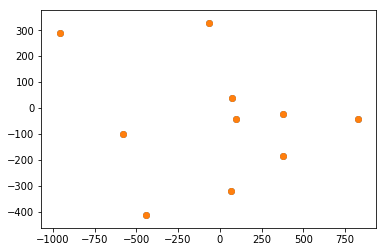

In [62]:
plt.scatter(strokes_[:,0],strokes_[:,1])
plt.show()

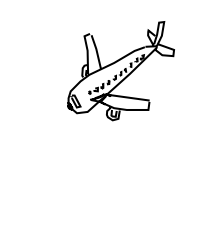

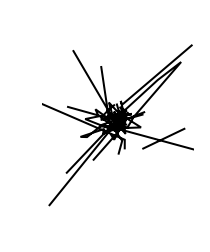

In [148]:
### demo of the difference between the absolute pen position and the relative pen position
plt.figure()
inds = list(S[(S.photoID=='n02691156_10151') & (S.sketchID==0)].index)
verts = zip(S1.loc[inds].x.values,S1.loc[inds].y.values)
codes = S1.loc[inds].pen.values
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax = plt.subplot(121)
ax.add_patch(patch)
ax.set_xlim(0,600)
ax.set_ylim(0,600) 
ax.axis('off')
plt.gca().invert_yaxis() # y values increase as you go down in image
plt.show()

inds = list(S[(S.photoID=='n02691156_10151') & (S.sketchID==0)].index)
verts = zip(S2.loc[inds].x.values,S2.loc[inds].y.values)
codes = S2.loc[inds].pen.values
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax = plt.subplot(122)
ax.add_patch(patch)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200) 
ax.axis('off')
plt.gca().invert_yaxis() # y values increase as you go down in image
plt.show()

In [20]:
# a = tf.constant([2.,2.,1.,2.,2.,1.,1.,2.,1.,2.])
# b = tf.constant([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
# result =  tf.nn.softmax_cross_entropy_with_logits(labels=a,logits=b)
# sess = tf.InteractiveSession()
# sess.run(tf.initialize_all_variables())
# print result.eval()

### run rnn version

In [150]:
# RANDOM_SEED = 42
# tf.set_random_seed(RANDOM_SEED)

# # reset entire graph
# tf.reset_default_graph()

# # weight on offset loss
# offset_weight = 1000.

# # learning rate
# learning_rate = 0.01

# # set batch size
# batch_size = 10

# # epoch counter
# epoch_num = 0

# # max strokes
# max_strokes = 200

# # initialize variables
# F = tf.placeholder("float", shape=[None, 2048])  # features (input)
# S = tf.placeholder("float", shape=[None, 3]) # strokes (output)

# # layer sizes
# x_size = F.shape[1]   # Number of input nodes: 2048 features and 1 bias
# h_size = 512        # Number of hidden nodes
# y_size = S.shape[1]   # Number of outcomes (x,y,pen)

# # rnn hyperparameters
# rnn_hidden_size = 512 # number of rnn hidden units

# output = tf.placeholder("float", shape=[None,y_size])

# # convert to tensorflow tensor
# F = tf.cast(tf.stack(F,name='F'),tf.float32)
# S = tf.cast(tf.stack(S,name='S'),tf.float32)

# # Weight initializations
# W1 = tf.get_variable('W1', [x_size, h_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
# b1 = tf.get_variable('b1', [h_size],initializer=tf.zeros_initializer(), dtype=tf.float32)
# W2 = tf.get_variable('W2', [h_size, y_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
# b2 = tf.get_variable('b2', [y_size],initializer=tf.zeros_initializer(), dtype=tf.float32)

# # forward propagation
# # Run RNN and run linear layer to fit to correct size.

# rnn_input = tf.nn.xw_plus_b(F, W1, b1,name='rnn_input')
# cell = tf.contrib.rnn.BasicLSTMCell(rnn_hidden_size)
# starting_state = cell.zero_state(batch_size=batch_size, dtype=tf.float32)
# outputs, final_rnn_state = tf.contrib.rnn.static_rnn(cell, 
#                             [rnn_input]*max_strokes,
#                             initial_state=starting_state,
#                             dtype=tf.float32)
# W_hy = tf.get_variable('W_hy', [rnn_hidden_size, y_size],initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)

# preds = []
# for output in outputs:
#     preds.append(tf.matmul(outputs, W_hy))


# # output = tf.nn.xw_plus_b(fc1, W2, b2,name='output')

# # actual_offset = tf.slice(S,[0,0],[batch_size,2])
# # actual_pen = tf.slice(S,[0,2],[batch_size,-1]) 
# # pred_offset = tf.multiply(tf.slice(output,[0,0],[batch_size,2]),offset_weight)
# # pred_pen = tf.nn.softmax(tf.slice(output,[0,2],[batch_size,-1]))

# # offset_loss = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(pred_offset,actual_offset)),axis=1)))
# # pen_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
# #             labels = actual_pen,
# #             logits = pred_pen))

# # loss = tf.add(offset_loss,pen_loss)

# # # run backprop
# # optimizer = tf.train.AdamOptimizer(learning_rate)
# # train_op = optimizer.minimize(loss)

# # saver
# save = False
# saver = tf.train.Saver()

# # # get predicted stroke vector
# # strokes = tf.concat([pred_offset, pred_pen],axis=1)

# # run batches
# with tf.Session() as sess:
#     tf.global_variables_initializer().run()
#     for m in get_minibatches([F_train,S_train.as_matrix()],batch_size,shuffle=True):

#         if m[0].shape[0]==batch_size:
#             F_batch = m[0]
#             S_batch = m[1]    

#             updates = sess.run([preds], feed_dict={F:F_batch,S:S_batch})    

#             preds_ = updates[0]

#             if epoch_num%200==0:
#                 print "Epoch: " + str(epoch_num) 

#             # save
#             if save:
#                 saver.save(sess, 'checkpoints/pix2svg_train_rnn_0')
                
#             # increment epoch number
#             epoch_num += 1


In [337]:
# for epoch in range(50):
#     # Train with each examplea
#     for i in range(len(F_batch)):
#         sess.run(updates, feed_dict={X: F_batch[i: i + 1], y: S_batch[i: i + 1]})
        
#         loss = sess.run(output, feed_dict={X: F_batch, y: S_batch})      

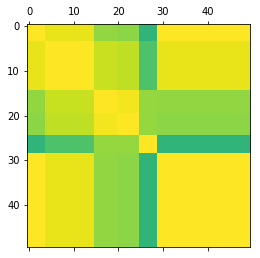

In [290]:
fig = plt.figure()
im = plt.matshow(np.corrcoef(F_batch_array),vmin=0.5)
plt.show()

In [20]:
sess.close()

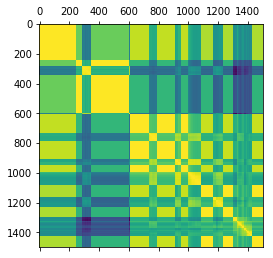

In [174]:
# get minibatch
batch_size = 1500
F_batch = F_train[:batch_size,:]
S_batch = S_train.head(n=batch_size)

# reserve numpy version 
F_batch_array = F_batch
S_batch_array = S_batch.as_matrix()

plt.matshow(np.corrcoef(F_batch_array))
plt.show()

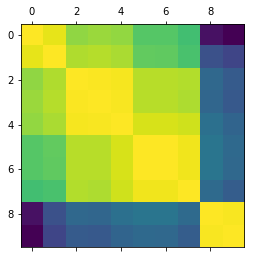

In [198]:
SF_ = SF[100:110,:]
plt.matshow(np.corrcoef(SF_))
plt.show()

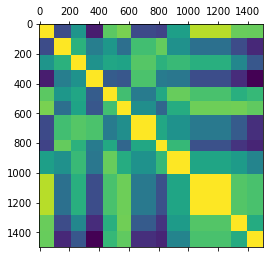

In [200]:
PF_ = PF[:batch_size,:]
plt.matshow(np.corrcoef(PF_))
plt.show()